<a href="https://colab.research.google.com/github/Samir-atra/Other/blob/main/Capsa_experience/Capsa_Copy_of_Train%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Imports

from google.colab import drive             
drive.mount('/content/drive')

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pathlib
import IPython
import sys
import matplotlib.pyplot as plt
!pip install keras_tuner -q
import keras_tuner
# !pip install git+https://github.com/themis-ai/capsa.git
%cd drive/MyDrive/capsa-main-folder
!python setup.py install
import capsa
!pip install git+https://github.com/aamini/introtodeeplearning.git@2023
import mitdeeplearning as mdl
from capsa import EnsembleWrapper, DropoutWrapper, VAEWrapper
!pip install helper
import helper
from array_dataset import dataset



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/capsa-main-folder'
/content/drive/.shortcut-targets-by-id/1XCrJCA5oUiJAyoSgAsLKpYFvzqyKrmxc/capsa-main-folder
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarni

In [12]:
# Dataset loading

data_path = pathlib.Path('/content/drive/MyDrive/archiveX3/Training/')
data_path_test = pathlib.Path('/content/drive/MyDrive/archiveX3/Testing/')

dataset_path = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels= 'inferred',
    # validation_split=0.2,
    # subset='training',
    seed= 1,
    batch_size=64,
    image_size=(64, 64),
    color_mode="rgb")
    # shuffle=True)

test_images, test_labels = dataset(data_path)

dataset_path_test = tf.keras.utils.image_dataset_from_directory(
    data_path_test,
    labels= 'inferred',
    seed= 3,
    batch_size=64,
    image_size=(64, 64),
    color_mode="rgb")
    # shuffle=True)

efficientnet_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels= 'inferred',
    seed= 3,
    batch_size=64,
    image_size=(240, 240),
    color_mode="rgb")

num_classes = 1



Found 4096 files belonging to 2 classes.
Found 931 files belonging to 2 classes.
Found 4096 files belonging to 2 classes.


In [15]:
# Encoder, Decoder, and transfer learning base model


encoder = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, 3, strides = 2, padding = "same",  activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),                                                                         #DP1
    tf.keras.layers.Conv2D(32, 3, strides = 2, padding = "same", activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),                                                                         #DP2
    tf.keras.layers.Conv2D(64, 3, strides = 2, padding = "same", activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, 1, strides = 2, padding = "same", activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),                                                                         #DP3
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 512, activation='relu'),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),                                                                         #DP4                                                                        #DP5
    tf.keras.layers.Dense(num_classes, activation= None)
])


decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(units=4*4*128),  
        tf.keras.layers.Reshape((4, 4, 128)),
        tf.keras.layers.Conv2DTranspose(64, 1,  strides=2, padding = "same", activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, 3,  strides=2, padding = "same", activation='relu'),
        tf.keras.layers.Conv2DTranspose(16, 3,  strides=2, padding = "same", activation='relu'),
        tf.keras.layers.Conv2DTranspose(3, 3,  strides=2, padding = "same"),
    ])

base_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2", trainable=False),  
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
base_model.build([None, 240, 240, 3]) 


In [17]:
# HistogramVAE Wrapper

wrapped_model = capsa.HistogramVAEWrapper(encoder, num_bins=5, queue_size=20000, latent_dim = 64, decoder=decoder)

wrapped_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss= tf.losses.BinaryCrossentropy(from_logits= True),
    metrics= [tf.keras.metrics.BinaryAccuracy()]
)


history = wrapped_model.fit(
    dataset_path,
    epochs=30)                                    
    #validation_data = dataset_path_val)


out = wrapped_model.predict(test_images, batch_size=512)

indices = np.argsort(out.bias, axis=None) 
sorted_images = test_images[indices]
sorted_biases = out.bias.numpy()[indices]
sorted_preds = out.y_hat.numpy()[indices]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(sorted_images[-20:], (4, 5)))
ax[0].set_title("Over-represented")

ax[1].imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))
ax[1].set_title("Under-represented");

plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

Epoch 1/30


64/64 [==============================] - 16s 110ms/step - vae_compiled_loss: nan - vae_compiled_binary_accuracy: 0.5218 - vae_wrapper_loss: nan


KeyboardInterrupt: ignored

In [ ]:
# MVE Wrapper

mve_model = capsa.MVEWrapper(encoder, is_classification=True)
# mve_model = capsa.MVEWrapper(base_model, is_classification=True)


mve_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.BinaryAccuracy()], 
    run_eagerly=True
)

history = mve_model.fit(
        dataset_path,
        epochs=6,
        batch_size=64,
  )

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = dataset_path.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = dataset_path_test.map(lambda x, y: (normalization_layer(x), y))

images = np.vstack((normalized_test_ds, normalized_train_ds))


Epoch 1/6


64/64 [==============================] - 16s 104ms/step - mve_compiled_loss: 0.8749 - mve_compiled_binary_accuracy: 0.6866 - mve_wrapper_loss: 129.8828
Epoch 2/6
64/64 [==============================] - 8s 108ms/step - mve_compiled_loss: 0.6941 - mve_compiled_binary_accuracy: 0.7684 - mve_wrapper_loss: 129.8919
Epoch 3/6
64/64 [==============================] - 7s 97ms/step - mve_compiled_loss: 0.5540 - mve_compiled_binary_accuracy: 0.7901 - mve_wrapper_loss: 129.9135
Epoch 4/6
64/64 [==============================] - 8s 116ms/step - mve_compiled_loss: 0.4791 - mve_compiled_binary_accuracy: 0.8136 - mve_wrapper_loss: 129.7840
Epoch 5/6
64/64 [==============================] - 7s 96ms/step - mve_compiled_loss: 0.4462 - mve_compiled_binary_accuracy: 0.8215 - mve_wrapper_loss: 129.6052
Epoch 6/6
64/64 [==============================] - 8s 116ms/step - mve_compiled_loss: 0.4258 - mve_compiled_binary_accuracy: 0.8231 - mve_wrapper_loss: 130.0332


In [ ]:
# Ensemble Wrapper

Ensemble_wrapped_model = EnsembleWrapper(encoder, num_members=1)


Ensemble_wrapped_model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
                     )

history = Ensemble_wrapped_model.fit(
        dataset_path,
        epochs=12,
        batch_size=64,
  )



Epoch 1/12
64/64 [==============================] - 13s 116ms/step - usermodel_0_compiled_loss: 5.3524 - usermodel_0_compiled_binary_accuracy: 0.6049
Epoch 2/12
64/64 [==============================] - 8s 103ms/step - usermodel_0_compiled_loss: 4.7342 - usermodel_0_compiled_binary_accuracy: 0.6634
Epoch 3/12
64/64 [==============================] - 8s 112ms/step - usermodel_0_compiled_loss: 4.6342 - usermodel_0_compiled_binary_accuracy: 0.6762
Epoch 4/12
64/64 [==============================] - 7s 96ms/step - usermodel_0_compiled_loss: 4.5608 - usermodel_0_compiled_binary_accuracy: 0.6850
Epoch 5/12
64/64 [==============================] - 8s 116ms/step - usermodel_0_compiled_loss: 4.4383 - usermodel_0_compiled_binary_accuracy: 0.6953
Epoch 6/12
64/64 [==============================] - 7s 95ms/step - usermodel_0_compiled_loss: 4.3663 - usermodel_0_compiled_binary_accuracy: 0.7008
Epoch 7/12
64/64 [==============================] - 8s 116ms/step - usermodel_0_compiled_loss: 4.2796 - use

In [ ]:
# Dropout Wrapper

dropout_model = DropoutWrapper(encoder, p=0.5)
# dropout_model = DropoutWrapper(base_model, p=0.5)


dropout_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
                     )

history = dropout_model.fit(
        dataset_path,
        epochs=12,
        batch_size=64,
  )

Epoch 1/12
64/64 [==============================] - 11s 93ms/step - dropout_compiled_loss: 4.7235 - dropout_compiled_binary_accuracy: 0.6036 - dropout_wrapper_loss: 4.5719
Epoch 2/12
64/64 [==============================] - 8s 116ms/step - dropout_compiled_loss: 4.4896 - dropout_compiled_binary_accuracy: 0.6457 - dropout_wrapper_loss: 4.4659
Epoch 3/12
64/64 [==============================] - 7s 99ms/step - dropout_compiled_loss: 4.1457 - dropout_compiled_binary_accuracy: 0.6689 - dropout_wrapper_loss: 4.1899
Epoch 4/12
64/64 [==============================] - 7s 95ms/step - dropout_compiled_loss: 4.3173 - dropout_compiled_binary_accuracy: 0.6628 - dropout_wrapper_loss: 4.1153
Epoch 5/12
64/64 [==============================] - 8s 114ms/step - dropout_compiled_loss: 4.0278 - dropout_compiled_binary_accuracy: 0.6916 - dropout_wrapper_loss: 3.8949
Epoch 6/12
64/64 [==============================] - 7s 95ms/step - dropout_compiled_loss: 4.1148 - dropout_compiled_binary_accuracy: 0.6767 - 

In [ ]:
# VAE Wrapper

vae_model = VAEWrapper(encoder, decoder=decoder)

vae_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0000001),
    loss= tf.losses.BinaryCrossentropy(from_logits= True),
    metrics= [tf.keras.metrics.BinaryAccuracy()]
)

history = vae_model.fit(
    dataset_path,
    epochs=3,                                    
    validation_data = dataset_path_val)



Epoch 1/10
64/64 [==============================] - 12s 95ms/step - dropout_0_compiled_loss: 7.7317 - dropout_0_wrapper_loss: 7.3456
Epoch 2/10
64/64 [==============================] - 8s 117ms/step - dropout_0_compiled_loss: 6.1625 - dropout_0_wrapper_loss: 2.8866
Epoch 3/10
64/64 [==============================] - 7s 98ms/step - dropout_0_compiled_loss: 4.4273 - dropout_0_wrapper_loss: 1.2417
Epoch 4/10
64/64 [==============================] - 8s 117ms/step - dropout_0_compiled_loss: 3.4243 - dropout_0_wrapper_loss: 0.7494
Epoch 5/10
64/64 [==============================] - 7s 97ms/step - dropout_0_compiled_loss: 2.7983 - dropout_0_wrapper_loss: 0.5420
Epoch 6/10
64/64 [==============================] - 7s 96ms/step - dropout_0_compiled_loss: 2.3762 - dropout_0_wrapper_loss: 0.4300
Epoch 7/10
64/64 [==============================] - 8s 107ms/step - dropout_0_compiled_loss: 2.0694 - dropout_0_wrapper_loss: 0.3441
Epoch 8/10
64/64 [==============================] - 8s 111ms/step - drop

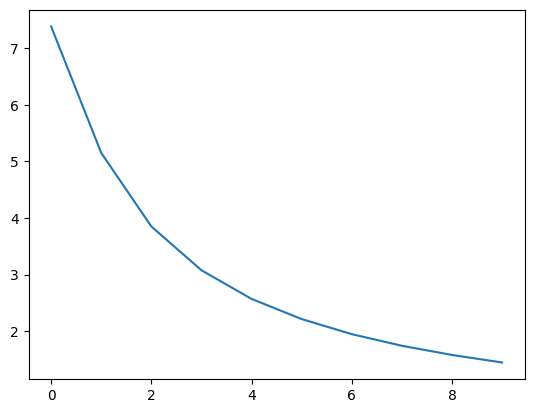

In [ ]:
# Composibility

two_models = EnsembleWrapper(encoder, num_members=1, metric_wrapper=DropoutWrapper, kwargs={'p': 0.2})

two_models.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
)

history = two_models.fit(
    dataset_path,
    epochs=10,
)

d = history.history
d = {key: value for key, value in d.items() if "compiled" in key}
for key, value in d.items():
    plt.plot(value, label=key)

plt.show()